# Modelo de Classificação de Intenções com CNN e LSTM

Este notebook implementa uma rede neural para classificar a intenção de um usuário (`intent`) em uma categoria de serviço (`service_name`) com base em uma frase de entrada.

A arquitetura do modelo combina:
- **Camadas Convolucionais (Conv1D)**: Para extrair características locais e n-gramas do texto.
- **Camadas Recorrentes (LSTM)**: Para entender o contexto e as dependências sequenciais nas características extraídas.

### 1. Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

### 2. Carregamento e Pré-processamento dos Dados

Carregamos o arquivo CSV, definimos o delimitador e separamos as colunas de entrada (`intent`) e de alvo (`service_name`).

In [2]:
# O caminho para o CSV de TREINAMENTO é relativo à localização deste notebook
# csv_path_train = '../../../assets/intents_generated.csv'
csv_path_train = 'intents_generated.csv'

df_train = pd.read_csv(csv_path_train, delimiter=';')

# Remover linhas com valores ausentes
df_train.dropna(subset=['intent', 'service_name'], inplace=True)

# Definir textos (X) e rótulos (y) para o treino
intents_train = df_train['intent'].values
service_names_train = df_train['service_name'].values

print("Dados de Treinamento Carregados:")
df_train.head()

Dados de Treinamento Carregados:


,service_id,service_name,intent
0,1,Consulta Limite / Vencimento do cartão / Melho...,qual meu limite disponível
1,1,Consulta Limite / Vencimento do cartão / Melho...,consultar limite do cartão
2,1,Consulta Limite / Vencimento do cartão / Melho...,quanto posso gastar no cartão
3,1,Consulta Limite / Vencimento do cartão / Melho...,ver saldo disponível cartão
4,1,Consulta Limite / Vencimento do cartão / Melho...,data de vencimento da fatura


In [3]:
# O caminho para o CSV de AVALIAÇÃO é relativo à localização deste notebook
csv_path_test = 'intents_pre_loaded.csv'

df_test = pd.read_csv(csv_path_test, delimiter=';')

# Remover linhas com valores ausentes
df_test.dropna(subset=['intent', 'service_name'], inplace=True)

# Definir textos (X) e rótulos (y) para o teste
intents_test = df_test['intent'].values
service_names_test = df_test['service_name'].values

print("\nDados de Avaliação Carregados:")
df_test.head()


Dados de Avaliação Carregados:


,service_id,service_name,intent
0,1,Consulta Limite / Vencimento do cartão / Melho...,Quanto tem disponível para usar
1,1,Consulta Limite / Vencimento do cartão / Melho...,quando fecha minha fatura
2,1,Consulta Limite / Vencimento do cartão / Melho...,Quando vence meu cartão
3,1,Consulta Limite / Vencimento do cartão / Melho...,quando posso comprar
4,1,Consulta Limite / Vencimento do cartão / Melho...,vencimento da fatura


### 3. Codificação dos Rótulos (Labels)

As redes neurais trabalham com números. Usamos o `LabelEncoder` para converter os nomes dos serviços (texto) em números inteiros.

In [4]:
# Combinar todos os rótulos para garantir que o LabelEncoder conheça todas as classes
all_service_names = np.concatenate([service_names_train, service_names_test])

label_encoder = LabelEncoder()
label_encoder.fit(all_service_names)

# Codificar os rótulos de treino e de teste
y_train_encoded = label_encoder.transform(service_names_train)
y_test_encoded = label_encoder.transform(service_names_test)

num_classes = len(label_encoder.classes_)

print(f"Número de classes de serviço: {num_classes}")
print(f"Exemplo de rótulo de treino codificado: {y_train_encoded[:5]}")
print(f"Exemplo de rótulo de teste codificado: {y_test_encoded[:5]}")

Número de classes de serviço: 16
Exemplo de rótulo de treino codificado: [2 2 2 2 2]
Exemplo de rótulo de teste codificado: [2 2 2 2 2]


### 4. Tokenização e Padding

O texto é convertido em sequências de números (`Tokenização`) e, em seguida, todas as sequências são padronizadas para ter o mesmo comprimento (`Padding`).

In [5]:
# Configurações
# vocab_size = 1000  # Tamanho máximo do vocabulário
max_length = 20    # Comprimento máximo das sequências
embedding_dim = 64 # Dimensão dos vetores de embedding

# Criar e treinar o tokenizer com os dados de TREINO
# Removido o limite de vocab_size para usar todas as palavras
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(intents_train)

# Adicionar 1 ao tamanho do vocabulário para o token <unk>
vocab_size = len(tokenizer.word_index) + 1

# Converter textos de treino para sequências de inteiros
X_train_sequences = tokenizer.texts_to_sequences(intents_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')

# Converter textos de teste para sequências de inteiros
X_test_sequences = tokenizer.texts_to_sequences(intents_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Tamanho do vocabulário: {vocab_size}")

Tamanho do vocabulário: 343


### 6. Construção do Modelo (CNN + LSTM)

In [6]:
model = Sequential([
    # Camada de Embedding: Transforma índices de palavras em vetores densos
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

    # Camada Convolucional (CNN): Extrai características locais
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),

    # Camada Recorrente Bidirecional (LSTM): Aprende padrões sequenciais em ambas as direções
    Bidirectional(LSTM(64)),
    Dropout(0.5),

    # Camada de Saída: Classifica nas categorias de serviço
    Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # Usar para rótulos inteiros
    metrics=['accuracy']
)

model.summary()

d:\fcf\code\credsystem-hackathon-2025-10-25\participantes\bandidos-do-byte\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 7. Treinamento do Modelo

In [7]:
# Definir o callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a ser monitorada
    patience=5,          # Número de épocas sem melhora antes de parar
    restore_best_weights=True  # Restaurar os pesos do melhor modelo
)

history = model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=30,
    validation_data=(X_test_padded, y_test_encoded),
    batch_size=16,
    callbacks=[early_stopping],  # Adicionar o callback aqui
    verbose=2
)

Epoch 1/30
40/40 - 2s - 60ms/step - accuracy: 0.0656 - loss: 2.7757 - val_accuracy: 0.0753 - val_loss: 2.7655
Epoch 2/30
40/40 - 2s - 60ms/step - accuracy: 0.0656 - loss: 2.7757 - val_accuracy: 0.0753 - val_loss: 2.7655
Epoch 2/30
40/40 - 0s - 7ms/step - accuracy: 0.1016 - loss: 2.7585 - val_accuracy: 0.1398 - val_loss: 2.7411
Epoch 3/30
40/40 - 0s - 7ms/step - accuracy: 0.1016 - loss: 2.7585 - val_accuracy: 0.1398 - val_loss: 2.7411
Epoch 3/30
40/40 - 0s - 6ms/step - accuracy: 0.2000 - loss: 2.6460 - val_accuracy: 0.2473 - val_loss: 2.4690
Epoch 4/30
40/40 - 0s - 6ms/step - accuracy: 0.2000 - loss: 2.6460 - val_accuracy: 0.2473 - val_loss: 2.4690
Epoch 4/30
40/40 - 0s - 6ms/step - accuracy: 0.3266 - loss: 2.0191 - val_accuracy: 0.4301 - val_loss: 1.8267
Epoch 5/30
40/40 - 0s - 6ms/step - accuracy: 0.3266 - loss: 2.0191 - val_accuracy: 0.4301 - val_loss: 1.8267
Epoch 5/30
40/40 - 0s - 7ms/step - accuracy: 0.5469 - loss: 1.3921 - val_accuracy: 0.5161 - val_loss: 1.4180
Epoch 6/30
40/40 

### 8. Avaliação do Modelo

In [8]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded, verbose=0)
print(f"\nAcurácia no conjunto de teste: {accuracy:.4f}")


Acurácia no conjunto de teste: 0.7849


### 8.1. Matriz de Confusão

Para visualizar o desempenho do modelo em mais detalhes, geramos uma matriz de confusão. Ela mostra quais classes estão sendo confundidas umas com as outras.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Relatório de Classificação:

                                                               precision    recall  f1-score   support

                                           Atendimento humano       1.00      1.00      1.00         5
                                       Cancelamento de cartão       0.38      0.60      0.46         5
Consulta Limite / Vencimento do cartão / Melhor dia de compra       0.80      0.67      0.73         6
                                            Consulta do Saldo       1.00      0.83      0.91         6
                                        Desbloqueio de Cartão       1.00      0.67      0.80         6
                              Esqueceu senha / Troca de senha       1.00      0.83      0.91         6
                                          Pagamento de contas       0.80      0.80      0.80         5
                                                Perda e roubo       0.

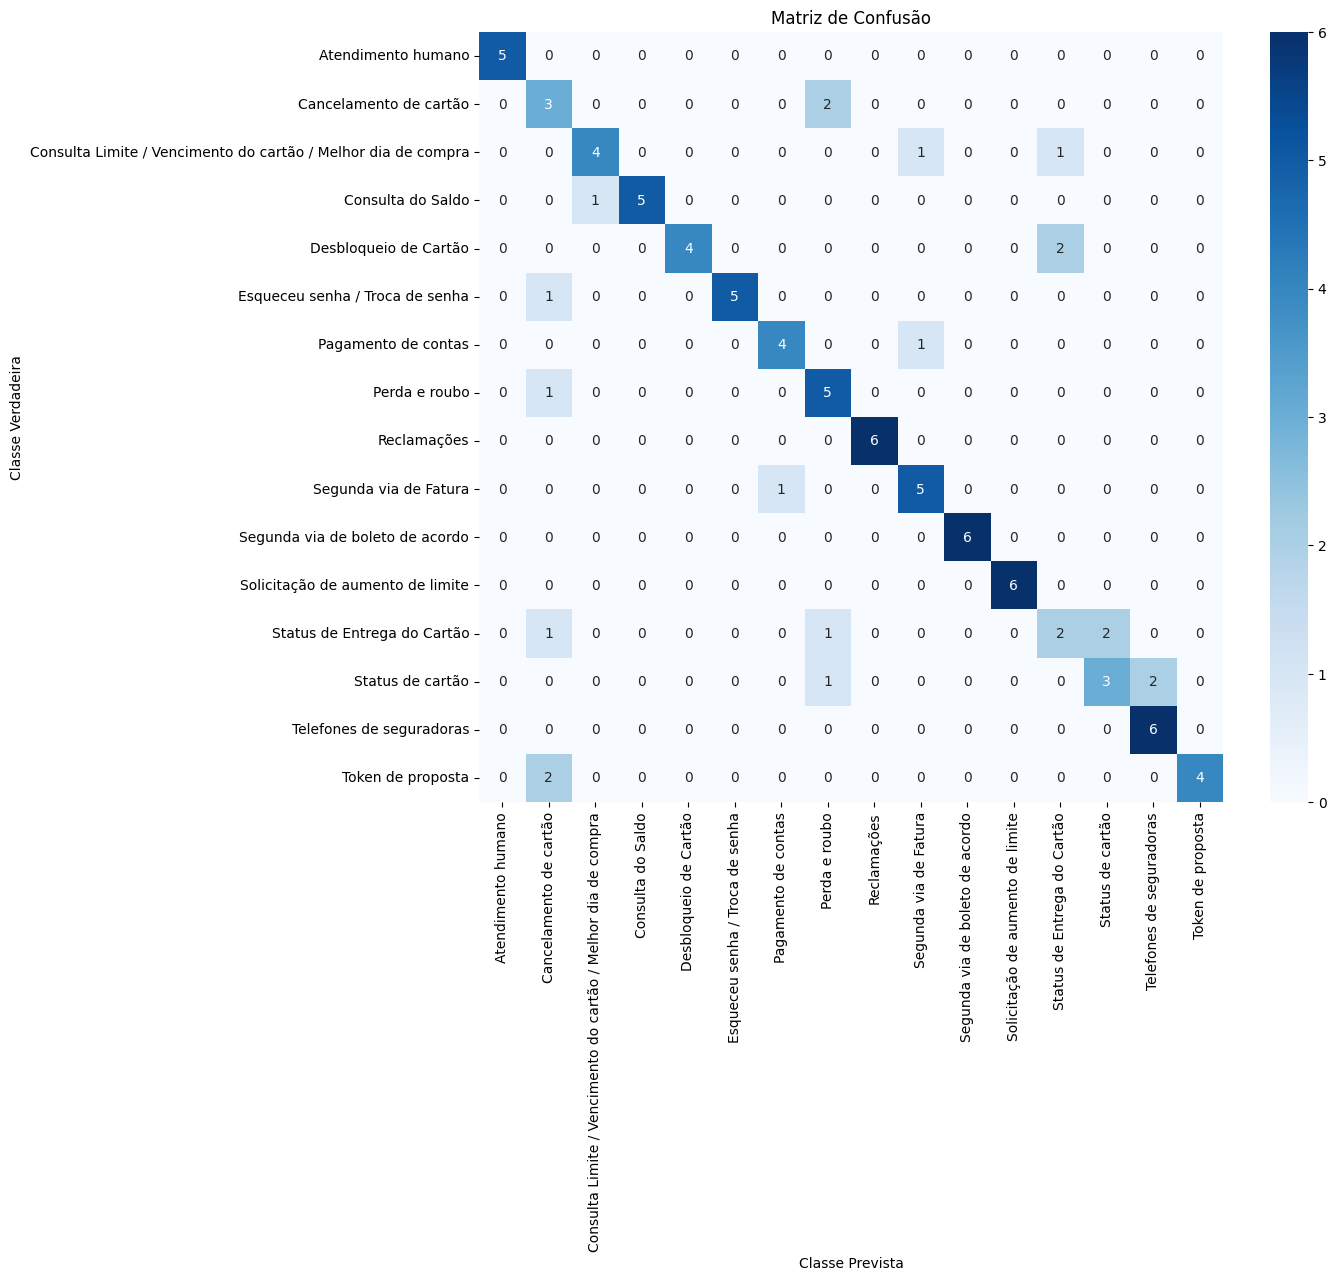

In [13]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nomes das classes para os eixos
class_names = label_encoder.classes_

# Imprimir o relatório de classificação
print("Relatório de Classificação:\n")
print(classification_report(y_test_encoded, y_pred_classes, target_names=class_names))

# Gerar a matriz de confusão
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

### 8.2. Gráficos de Treinamento

Para entender melhor o comportamento do modelo durante o treinamento, podemos plotar a acurácia e a perda (loss) ao longo das épocas.

In [ ]:
# Plotar o histórico de treinamento
plt.figure(figsize=(12, 4))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.show()

### 9. Função para Predição

Criamos uma função auxiliar para encapsular todo o processo de pré-processamento e predição para uma nova frase.

In [14]:
def predict_service(text):
    # Pré-processar o texto de entrada
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Fazer a predição
    prediction = model.predict(padded_sequence)
    predicted_class_index = np.argmax(prediction)

    # Decodificar o resultado para o nome do serviço
    predicted_service_name = label_encoder.inverse_transform([predicted_class_index])

    return predicted_service_name[0]

### 10. Teste do Modelo com Novas Frases

In [12]:
# Save the model
model.save('service_intent_model_3.h5')

### 11. Geração de Dados Sintéticos (Opcional)

Para aumentar a robustez do modelo, podemos gerar dados sintéticos. A célula abaixo cria um novo arquivo CSV com 100 exemplos de frases para cada categoria de serviço, totalizando 1600 novas amostras.

**Atenção**: Execute esta célula apenas uma vez para criar o arquivo.

In [16]:
import pandas as pd
import random
import os

# Dicionário com os serviços e templates de frases
services_data = {
    "Consulta Limite / Vencimento do cartão / Melhor dia de compra": [
        "qual o limite do meu cartão?", "quanto ainda tenho de limite?", "meu limite disponível",
        "quando vence minha fatura?", "qual a data de vencimento?", "vencimento da fatura",
        "melhor dia para comprar", "qual o melhor dia de compra?", "dia bom para usar o cartão"
    ],
    "Segunda via de boleto de acordo": [
        "preciso da segunda via do meu acordo", "gerar boleto da negociação", "não recebi o boleto do acordo",
        "enviar novamente o boleto do meu parcelamento", "código de barras do acordo", "pagar meu acordo"
    ],
    "Segunda via de Fatura": [
        "quero a segunda via da minha fatura", "me envia o boleto da fatura, por favor", "não achei minha fatura",
        "preciso do código de barras para pagar a fatura", "gerar fatura em PDF", "fatura detalhada"
    ],
    "Status de Entrega do Cartão": [
        "gostaria de saber onde está meu cartão", "qual o status da entrega do meu cartão?", "meu cartão já foi enviado?",
        "rastrear entrega do cartão", "previsão de chegada do cartão", "ainda não recebi meu cartão"
    ],
    "Status de cartão": [
        "meu cartão foi bloqueado?", "qual o status do meu cartão?", "o cartão está ativo para uso?",
        "não consigo usar meu cartão", "minha compra foi recusada", "verificar status do cartão"
    ],
    "Solicitação de aumento de limite": [
        "gostaria de pedir um aumento de limite", "como faço para ter mais limite?", "solicitar mais crédito",
        "aumentar o limite do meu cartão de crédito", "meu limite é baixo, posso aumentar?", "quero um limite maior"
    ],
    "Cancelamento de cartão": [
        "quero cancelar meu cartão", "como faço para cancelar o cartão?", "não quero mais ter este cartão",
        "encerrar minha conta do cartão", "cancelar o cartão de crédito", "desativar meu cartão permanentemente"
    ],
    "Telefones de seguradoras": [
        "qual o telefone do seguro do cartão?", "preciso do contato da seguradora", "como falo com o seguro?",
        "número para acionar o seguro", "cancelar seguro do cartão", "informações sobre a apólice de seguro"
    ],
    "Desbloqueio de Cartão": [
        "recebi meu cartão e quero desbloquear", "como desbloquear o cartão novo?", "desbloquear meu cartão agora",
        "ativar o cartão para compras", "meu cartão chegou, como ativo?", "quero usar meu cartão novo"
    ],
    "Esqueceu senha / Troca de senha": [
        "esqueci a senha do meu cartão, e agora?", "preciso cadastrar uma nova senha", "como altero a senha do cartão?",
        "não lembro minha senha", "quero trocar a senha", "ajuda para recuperar a senha"
    ],
    "Perda e roubo": [
        "perdi meu cartão, preciso bloquear", "fui roubado, levem meu cartão", "bloquear cartão por perda",
        "meu cartão foi furtado", "comunicar roubo de cartão", "extraviei meu cartão, o que fazer?"
    ],
    "Consulta do Saldo": [
        "qual o saldo da minha conta?", "gostaria de ver meu saldo", "quanto dinheiro eu tenho?",
        "consultar o extrato da conta", "verificar meu saldo atual", "meu saldo por favor"
    ],
    "Pagamento de contas": [
        "quero pagar uma conta de consumo", "pagar um boleto com a câmera", "agendar pagamento de conta",
        "realizar pagamento de boleto", "como pagar contas pelo app?", "pagar fatura de água"
    ],
    "Reclamações": [
        "gostaria de fazer uma reclamação", "quero registrar uma queixa sobre o atendimento", "não estou satisfeito com o serviço",
        "abrir um protocolo de reclamação", "reclamar sobre uma cobrança indevida", "tenho uma queixa"
    ],
    "Atendimento humano": [
        "preciso falar com um atendente", "quero ser transferido para uma pessoa", "falar com um especialista",
        "me ajuda a falar com um humano", "não quero falar com robô", "atendimento com uma pessoa, por favor"
    ],
    "Token de proposta": [
        "qual o token da minha proposta?", "não recebi o código do meu cartão", "informar token para finalizar a proposta",
        "cadê o número do token?", "preciso do token para continuar", "validar proposta com token"
    ]
}

# Gerar os dados
generated_data = []
for service, templates in services_data.items():
    for _ in range(100):
        intent = random.choice(templates)
        # Adicionar pequenas variações
        if random.random() > 0.7:
            intent = intent.replace("?", "").strip()
        if random.random() > 0.8:
            intent = "por favor, " + intent
        if random.random() > 0.9:
            intent = intent.upper()
            
        generated_data.append({"intent": intent, "service_name": service})

# Criar DataFrame
df_generated = pd.DataFrame(generated_data)

# Caminho para salvar o arquivo
output_path = 'intents_generated.csv'

# Criar o diretório se não existir
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Salvar em CSV
df_generated.to_csv(output_path, sep=';', index=False, encoding='utf-8-sig')

print(f"Arquivo '{output_path}' criado com {len(df_generated)} linhas.")
df_generated.head()

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: ''